<a href="https://colab.research.google.com/github/ferit-ml/su-24-25-lv3-dzijo/blob/main/SU%20LV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poboljšavanje učenja CNN

Postoje razni problemi do kojih dolazi zbog kojih neuronske mreže mogu imati loše rezultate. U ovom LV-u ćemo obraditi neke od načina poboljšavanja učenja neuronskih mreža. Radit ćemo na primjeru konvolucijske neuronske mreže, ali neke od ovih strategija mogu se primijeniti i na druge neuronske mreže.

## Hiperparametri

Parametri čije se vrijednosti postavljaju prije početka procesa treniranja mreže, a utječu na strukturu modela ili na efikasnost procesa učenja (kontroliraju tijek učenja).

Dvije skupine:
* Hiperparametri vezani za strukturu mreže: broj slojeva, veličina slojeva (npr. broj neurona ili broj filtara), tip aktivacijskih funkcija, veličina filtara, raspored slojeva itd.
* Algoritamski hiperparametri koji kontroliraju način na koji se mreža uči i kako se ažuriraju težine tijekom treninga: veličina batcha, optimizacijski algoritam, broj epoha, stopa učenja, odabir funkcije gubitka i sl.

#### Optimizacijski algoritam

Postoje razni optimiziacijski algoritmi, ali smo dosad na laboratorijskim vježbama koristili samo SGD (*stochastic gradient descent*). U Pytorchu su implementirati razni drugi [optimizacijski algoritmi](https://pytorch.org/docs/stable/optim.html). U zadnje vrijeme je Adam optimiziacijski algoritam vrlo popularan.

#### Stopa učenja

[Raspoređivanje stope učenja (engl. learning rate scheduling)](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR) je tehnika u optimizacijskim algoritmima gdje se stopa učenja dinamički mijenja tijekom vremena prema unaprijed definiranom rasporedu ili na temelju određenih pravila.

#### Veličina batcha

S većom veličinom batcha moguće je ubrzati proces treninga (iskorištava se paralelizam modernih GPU-ova), ali mogući su problemi s konvergencijom.

## Problem pretjeranog usklađivanja (*overfitting*) i problem podusklađivanja (*underfitting*)

Čest problem kod treniranja neuronskih mreža je pretjerano prilagođavanje na podatke za treniranje. Do ovoga dolazi kad neuronska mreža ima dobre performanse na trening podacima, ali na novim, testnim podacima ima loše performanse. Ovaj fenomen se često može uočiti pomoću krivulja funkcije gubitka (*loss curve*). Ako vrijednost funkcije gubitka opada na skupu za treniranje, a ne opada, ili ponekad i raste, na skupu za validaciju, možemo reći da dolazi do pretjeranog prilagođavanja na podatke za treniranje. Ovo se također može vidjeti i u performansama modela na istim skupovima, primjerice točnost može opadati na skupu za validaciju. Primjer krivulja funkcije gubitka na skupovima za testiranje i validaciju prikazan je na slici.

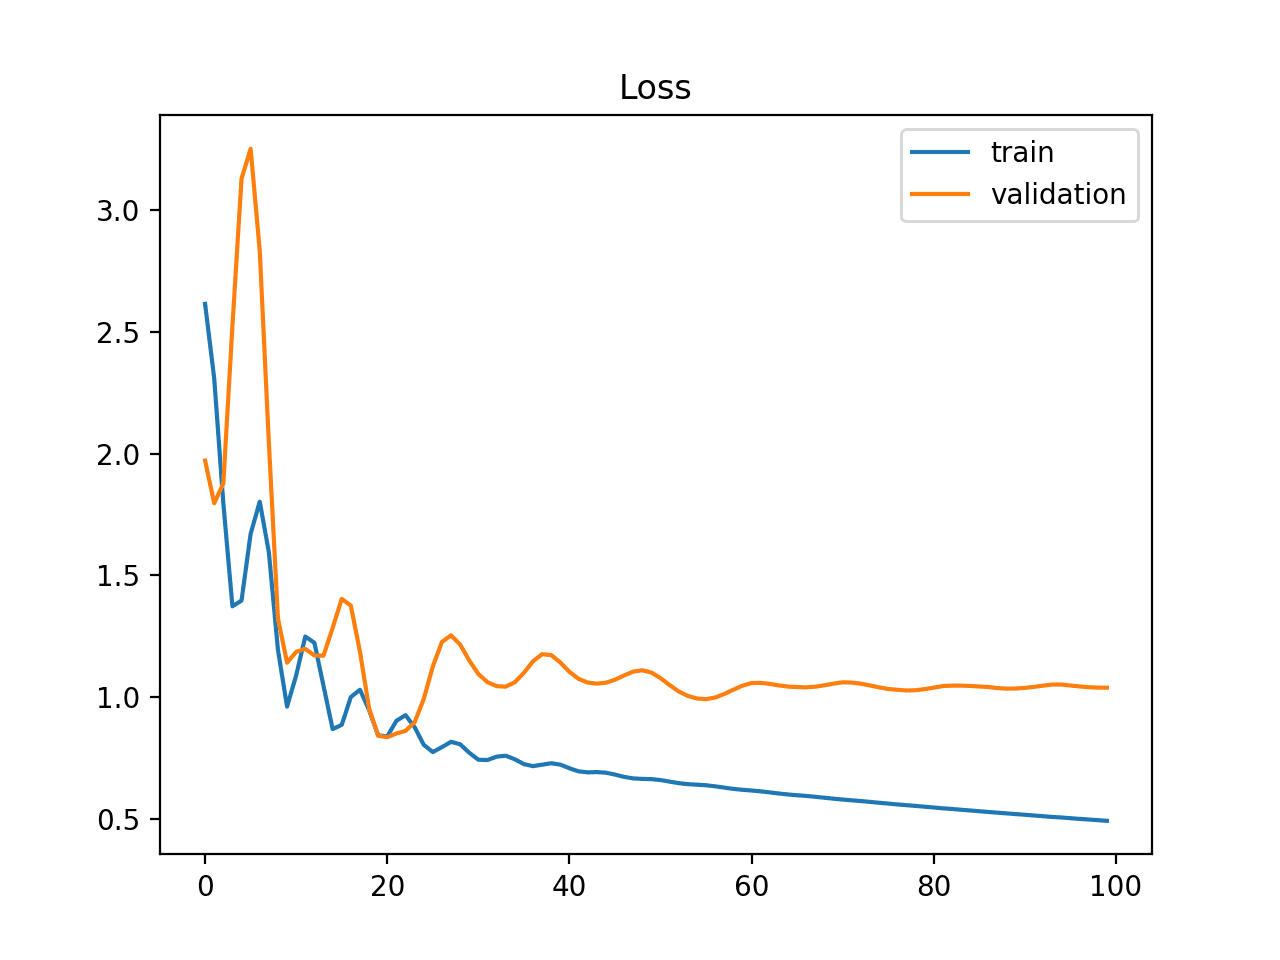

Također je čest i problem podusklađivanja (*underfitting*). Česti uzroci podusklađivanja uključuju:
 * Podaci za treniranje su loši i sadrže šumovite podatke
 * Model ima premali kapacitet za dani problem
 * Podatkovni skup za treniranje nije dovoljno velik
Lako je detektirati podusklađivanje jer će model u tom slučaju imati loše rezultate i na skupu za treniranje i na skupu za validaciju.

### Smanjivanje *overfittinga*

Postoje razne tehnike smanjivanja *overfittinga*:
* Rano zaustavljanje (engl. early stopping)
* Korištenjem [sloja s nasumičnim isključivanjem neurona (engl. dropout)](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
  * [Prostorni(*spatial*) *dropout*](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) uz konvolucijske slojeve
* Prikupljanje dodatnih primjera koji će se koristiti tijekom učenja
* [Augmentacija skupa za učenje](https://pytorch.org/vision/stable/transforms.html)
* Dodavanje regularizacijskih članova u kriterijsku funkciju (pomoću parametra `weight_decay`)
* Korištenjem [batch normalizacije (engl. batch normalization)](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
* Regularizacija modifikacijom kriterijske funkcije




### TensorBoard

TensorBoard je popularan alat za praćenje treniranja i vizualizaciju.

In [ ]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

In [ ]:
def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    ## TODO
    ## Calculate loss for the whole dataset
    running_loss = 0.


    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            _, pred_labels = torch.max(preds.data, dim=1) # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]

            loss = loss_module(preds, data_labels)
            running_loss += loss.item()


    acc = true_preds / num_preds
    running_loss /= len(data_loader)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    ## TODO
    ## Return the accuracy and the loss
    return acc, running_loss

PyTorchov TensorBoard API je jednostavan za korištenje. Praćenje treniranja se započinje kreiranjem objekta pisača, `writer = SummaryWriter(...)`, za koji je potrebno specificirati direktorij u koji će se spremati datoteka za praćenje treniranja. Pomoću ovog objekta, možemo pratiti razne apsekte modela prilikom treniranja pomoću funkcija `writer.add_...`. Primjerice, možemo dodati skalarnu vrijednost pomoću `writer.add_scalar`, ili možemo dodati graf napravljen korištenjem `matplotlib.pyplot` biblioteke pomoću `writer.add_figure`. U nastavku je primjer praćenja vrijednosti funkcije gubitka na skupu za treniranje.

In [ ]:
def train_model_with_logger(model, optimizer, train_data_loader, val_data_loader, loss_module, num_epochs=100, logging_dir='runs/our_experiment'):
    # Set model to train mode
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data_inputs, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            epoch_loss += loss.item() * len(data_inputs)

        # Add average loss to TensorBoard
        train_acc_, train_loss_ = eval_model(model, train_data_loader, loss_module)
        val_acc_, val_loss_ = eval_model(model, val_data_loader, loss_module)

        writer.add_scalars(f'loss', {
          'train': train_loss_,
          'validation': val_loss_,
        }, epoch + 1)

        writer.add_scalars(f'accuracy', {
          'train': train_acc_,
          'validation': val_acc_,
        }, epoch + 1)

    writer.close()

TensorBoard datoteka u odabranom direktoriju će sadržavati vrijednosti funkcije gubitka. Za pokretanje TensorBoard alata za vizualizaciju, pokrenite sljedeću naredbu:

## Zadataci

1. U funkciju za treniranje mreže dodajte i praćenje vrijednsoti funkcije gubitka na validacijskom skupu. Također dodajte i praćenje točnosti na oba skupa. Sve te vrijednsoti dodajte u TensorBoard *writer*.

2. U funkciju za treniranje mreže dodajte spremanje modela svakih nekoliko epoha.

3. Poboljšajte performanse konvolucijske neuronske mreže iz 2. laboratorijske vježbe pomoću nekih od navedenih tehnika:
* Isprobajte barem još jedan optimizacijski algoritam.
* Dodajte *dropout* i *spatial dropout* u CNN
* Dodajte *batch norm* u CNN
* Isprobajte treniranje uz *weight_decay*
* Dodajte augmentaciju skupa za učenje




In [ ]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

k = 0

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

whole_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
## TODO
## divide the trainset into trainset and valset
## containing 40000 and 10000 images respectively
trainset, valset = torch.utils.data.random_split(whole_trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
class CNN(nn.Module):

    def __init__(self, input_shape, out_classes):
        super().__init__()
        # Initialize the modules we need to build the network
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        ## determine the number of inputs to the linear layer dynamically
        flattened_features = self.get_number_of_features(input_shape)
        self.fc1 = nn.Linear(in_features=flattened_features, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=out_classes)

    def get_number_of_features(self, input_shape):
        x = torch.rand((1, *input_shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        return self.flatten(x).shape[1]

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN(input_shape=(3, 32, 32), out_classes=10).to(device)
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
k += 1
logging_dir = f'runs/experiment_{k}'
%tensorboard --logdir $logging_dir

In [ ]:
train_model_with_logger(model, optimizer, trainloader, valloader, loss_module, num_epochs=100, logging_dir=logging_dir)